<h1><center>Intro to Data Science Industry Project</h1></center>
<h2><center>Columbia University Professor Rating System</h2></center>

# Table of contents
- [Webscraping](#webscrapingslowcode)
- [Reading in scraped csv files](#readinginscrapedcsvfiles)
- [The Data](#dataset)
- [Getting Sentiment Scores using NLTK](#nltkpranjal)
- [Using Logistic Regression For Sentiment Analysis (using NLTK results as ground truth)](#modellingpranjal)
- [Using Random Forests For Sentiment Analysis (using NLTK results as ground truth](#modellingtreespranjal)
- [Unsupervised Analysis: PCA, NMF and Outlier Detection](#unsupervisedpranjal)
- [Old Code](#oldcode)

# Webscraping progress
- **[DONE: df_0_6950.csv]** 0 to 6950 
- **[DONE: df_6591_10k.csv]** 6591 to 10k 

- **[DONE: df_10k_20k.csv]** 10k to 20k 
- **[DONE: df_20k_25k.csv]** 20k to 25k 

- **[DONE: df_25k_30k.csv]** 25k to 30k 

- **[DONE: df_30k_37579.csv]** 30k to 37579 
- **[DONE: df_37580_40k.csv]** 37580 to 40k
- **[DONE: df_40k_43980.csv]** 40k to 43980 
- **[DONE: df_43980_50k.csv]** 43980 to 50k 
- **[DONE: df_50k_60k.csv]** 50k to 60k 
- **[DONE: df_60k_65k.csv]** 60k to 65k
- **[DONE: df_65k_67500.csv]** 65k to 67500

- **[DONE: df_67500_70k.csv]** 65k to 70k
- **[DONE: df_70k_80k.csv]** 70k to 80k 
- **[DONE: df_80k_90k.csv]** 80k to 90k 

- (or we could figure out multiprocessing or use scrapy)

## Import block

In [48]:
# Basic Libraries 
import pandas as pd
import numpy as np

# Web Scraping Tools 
from bs4 import BeautifulSoup 
from urllib.request import urlopen
import re

# NLTK
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#nltk.download() # only need to do this once

## Preprocessing for modelling
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MaxAbsScaler

# Modelling 

## Models
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer

## Unsupervised
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD

## Plotting
import mglearn
import matplotlib.pyplot as plt

## Genism
import gensim
from gensim import corpora

# progress tracker 
from tqdm import tqdm

## Webscraping (IDs 70000 to 80000) [Weida v2] <a name="webscrapingslowcode"></a>

In [28]:
i = 68577

url = 'http://culpa.info/reviews/{}'.format(i)
r = urlopen(url).read() 
soup = BeautifulSoup(r, "lxml") 
# if review doesn't exist, it redirects to home page, maybe use len() to check if we got redirected
#if len(soup.text) > 15500:
#    continue

In [14]:
len(soup.text)

14935

In [35]:
df = pd.DataFrame(columns=['review_id', 'review_date' ,'review_text', 'agree_score', 'disagree_score',
                             'funny_score', 'professor_id', 'professor_name', 'course_id', 'course_name'])
for i in tqdm(range(62500, 65000)):
    url = 'http://culpa.info/reviews/{}'.format(i)
    r = urlopen(url).read() 
    soup = BeautifulSoup(r, "lxml") 
    # if review doesn't exist, it redirects to home page, maybe use len() to check if we got redirected
    if len(soup.text) == 14935:
        continue
    
    professor = soup.find(href=re.compile('(professor)'))
    if professor == None:
        professor_id = None
        professor_name = None
    else:
        professor_id = professor['href'][12:]
        professor_name = professor.text
    
    courses = soup.find_all(href=re.compile('(courses)'))
    if courses == None:
        course_id = None
        course_name = None
    else:
        if str(courses[-1]).find('class') == -1:
            course_id = None
            course_name = None
        else:
            course_id = courses[-1]['href'][9:]
            course_name = courses[-1].text

    review_id = soup.find(href=re.compile('(reviews)'))['href'][9:]
    review_text = soup.find(class_='review_content').text
    review_date = pd.Timestamp(soup.find(class_='date').text.strip())
    agree_score = re.findall('\d+', soup.find(class_='agree')['value'])[0]
    disagree_score = re.findall('\d+', soup.find(class_='disagree')['value'])[0]
    funny_score = re.findall('\d+', soup.find(class_='funny')['value'])[0]

    to_append = pd.DataFrame(data=[review_id, review_date, review_text, agree_score, 
                                   disagree_score, funny_score, professor_id, professor_name,
                                   course_id, course_name],
                            index=['review_id', 'review_date' ,'review_text', 'agree_score', 
                                   'disagree_score', 'funny_score', 'professor_id', 
                                   'professor_name', 'course_id', 'course_name']).T
    
    df = pd.concat([df, to_append], ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [04:34<00:00,  9.12it/s]


In [17]:
df.professor_id = df.professor_id.apply(int)

In [36]:
# Export to csv
df.to_csv('df_62500_65k.csv')

## Webscraping for course ids

In [79]:
tofix = pd.read_csv('tofix_ids.csv', names=['id', 'tofix'])

In [83]:
df = pd.DataFrame(columns=['review_id','course_id', 'course_name'])

for i in tqdm(list(tofix.tofix)):
    url = 'http://culpa.info/reviews/{}'.format(i)
    r = urlopen(url).read() 
    soup = BeautifulSoup(r, "lxml") 
    
    review_id = i
    
    courses = soup.find_all(href=re.compile('(courses)'))
    if courses == None:
        course_id = None
        course_name = None
    else:
        if str(courses[-1]).find('class') == -1:
            course_id = None
            course_name = None
        else:
            course_id = courses[-1]['href'][9:]
            course_name = courses[-1].text
            
    to_append = pd.DataFrame(data=[review_id, course_id, course_name],
                            index=['review_id', 'course_id', 'course_name']).T
    
    df = pd.concat([df, to_append], ignore_index=True)


  0%|                                                                             | 26/25569 [00:04<1:20:05,  5.32it/s]


KeyboardInterrupt: 

#### Check out the scraped Data: First 5 Rows

In [49]:
df_70k_80k.head()

,Unnamed: 0,review_id,review_date,review_text,agree_score,disagree_score,funny_score,professor_id,professor_name,course_id,course_name
0,0,70013,2014-12-15 00:00:00,\nBest teacher I've ever had at Columbia. \nWo...,3.0,0.0,0.0,2080.0,"Neely, Evan (TA)",137,Art Hum
1,1,70014,2014-12-15 00:00:00,\nAlma Mora is the WORST professor I have had ...,0.0,0.0,0.0,NaN,NaN,242,[SPAN V1102] Elementary Spanish II
2,2,70144,2014-12-15 00:00:00,\nProf. Collins did a flipped classroom format...,6.0,0.0,0.0,10729.0,"Collins, Michael",4903,[COMS W4705] Natural Language Processing
3,3,70204,2014-12-15 00:00:00,\nI found this course to be a major disappoint...,4.0,2.0,0.0,3540.0,"Gundogdu, Ayten",137,Art Hum
4,4,70205,2014-12-15 00:00:00,\nProf Connor's class was very enjoyable. The ...,4.0,0.0,1.0,2350.0,"Connor, Peter",5547,[CPLT BC3110] Intro to Translation Studies


# Reading in scraped csv files <a name="readinginscrapedcsvfiles"></a>

In [41]:
import glob
pattern = 'data/*.csv'
csv_files = glob.glob(pattern)

In [42]:
csv_files

['data\\df_0k_10k.csv',
 'data\\df_10k_20k.csv',
 'data\\df_20k_25k.csv',
 'data\\df_25k_30k.csv',
 'data\\df_30k_40k.csv',
 'data\\df_40k_50k.csv',
 'data\\df_50k_60k.csv',
 'data\\df_60k_70k.csv',
 'data\\df_70k_80k.csv',
 'data\\df_80k_90k.csv']

In [50]:
frames = []
for csv in csv_files:
    df = pd.read_csv(csv)
    frames.append(df)

reviews = pd.concat(frames).drop(['Unnamed: 0', 'course_id', 'course_name'],axis=1)


In [53]:
tofix = reviews.review_id

In [63]:
tofix.to_csv('tofix_ids.csv')

# The Dataset Used <a name="dataset"></a>

In [4]:
df_70k_80k = pd.read_csv('data/df_70k_80k.csv')

In [5]:
df_70k_80k.agree_score = df_70k_80k.agree_score.apply(float)
df_70k_80k.disagree_score = df_70k_80k.disagree_score.apply(float)
df_70k_80k.funny_score = df_70k_80k.funny_score.apply(float)

In [6]:
df_70k_80k.head(5)

,Unnamed: 0,review_id,review_date,review_text,agree_score,disagree_score,funny_score,professor_id,professor_name,course_id,course_name
0,0,70013,2014-12-15 00:00:00,\nBest teacher I've ever had at Columbia. \nWo...,3.0,0.0,0.0,2080.0,"Neely, Evan (TA)",137,Art Hum
1,1,70014,2014-12-15 00:00:00,\nAlma Mora is the WORST professor I have had ...,0.0,0.0,0.0,NaN,NaN,242,[SPAN V1102] Elementary Spanish II
2,2,70144,2014-12-15 00:00:00,\nProf. Collins did a flipped classroom format...,6.0,0.0,0.0,10729.0,"Collins, Michael",4903,[COMS W4705] Natural Language Processing
3,3,70204,2014-12-15 00:00:00,\nI found this course to be a major disappoint...,4.0,2.0,0.0,3540.0,"Gundogdu, Ayten",137,Art Hum
4,4,70205,2014-12-15 00:00:00,\nProf Connor's class was very enjoyable. The ...,4.0,0.0,1.0,2350.0,"Connor, Peter",5547,[CPLT BC3110] Intro to Translation Studies


# Classifying Reviews using the Natural Language Toolkit <a name="nltkpranjal"></a>

#### Take a subset of the data  i.e. df_70k_80k for NLTK analysis

In [50]:
sid = SentimentIntensityAnalyzer()

In [51]:
subset = df_70k_80k 
reviews = subset['review_text'] # just the review column

In [52]:
all_pred_sentiments = []

for review in tqdm(reviews): # for each review, 
    pred_sentiment = sid.polarity_scores(review) # calculate the sentiment scores
    all_pred_sentiments.append(pred_sentiment) # and append them to a list

100%|██████████| 1790/1790 [00:05<00:00, 334.57it/s]


In [53]:
subset = pd.concat([subset, pd.DataFrame(all_pred_sentiments)], axis=1) # add these new columns to our dataframe

#### Add weights for Agree/Disagree scores and append *Weighted Scores* to the DataFrame

$$ Weight = \frac{Agree}{Agree + Disagree}$$

In [54]:
weight = np.multiply(subset['agree_score'], np.reciprocal(subset['agree_score'] + subset['disagree_score']))
weight = weight.fillna(1.0)
weight.name = 'weight'
subset = pd.concat([subset, weight], axis=1)
weighted_compound = np.multiply(np.transpose(subset['weight']), subset['compound'])
weighted_compound.name = 'weighted_compound'
subset = pd.concat([subset, weighted_compound], axis=1)

/Users/pranjalbajaj/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in reciprocal
  """Entry point for launching an IPython kernel.
/Users/pranjalbajaj/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in multiply
  """Entry point for launching an IPython kernel.


In [55]:
subset.shape

(1790, 17)

# Using Logistic Regression For Sentiment Analysis (using NLTK results as ground truth)  <a name="modellingpranjal"></a>

Since, we do not have labels for our data, we use the sentiments form NLTK as ground truth and build a logistic regression model. We are assuming that NLTK provides us the ground truth, which is NOT true but we do this for exploratory purposes only and see which words/features contribute to the predicted sentiment and hence use that to improve our model

#### 1. Make Classes from review scores

In [56]:
for i in tqdm(range(len(subset))):
    if subset['compound'][i] > 0:
        subset['compound'][i] = 1
    else:
        subset['compound'][i] = 0 

  0%|          | 0/1790 [00:00<?, ?it/s]/Users/pranjalbajaj/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
  0%|          | 1/1790 [00:00<13:17,  2.24it/s]/Users/pranjalbajaj/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
100%|██████████| 1790/1790 [01:34<00:00, 18.87it/s]


#### Check for missing values

In [16]:
print(subset['compound'].isnull().sum().sum())
print(subset['review_text'].isnull().sum().sum())

0
0


#### Check for imbalance in Dataset 

In [78]:
print("Positive Reviews: {:}".format(sum(subset["compound"] == 1)))
print("Negative Reviews: {:} ".format(sum(subset["compound"] == 0)))


Positive Reviews: 1505
Negative Reviews: 285 


Data is clearly imbalanced with more 12 times more positive reviews than negative reviews/

#### 2. Implement CountVectorizer and TfidfVectorizer to get bag of words

In [89]:
train = (df_70k_80k['review_text'].values).astype('U')

vect_count = CountVectorizer(stop_words='english').fit(train) #, ngram_range = (1, 1), min_df = 0.005
bag_count = vect_count.transform(train)

# feature names
feature_names_count = vect_count.get_feature_names()

vect_tfidf = TfidfVectorizer(stop_words='english').fit(train) #, ngram_range = (1, 1), min_df = 0.005
bag_tfidf = vect_tfidf.transform(train)

# feature names
feature_names_tfidf = vect_tfidf.get_feature_names()

y = subset['compound']

In [90]:
# Define Crossvalidation Strategy
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 9598)

#### 3 a) Run Model: Countvectorizer

#### Initial Model

In [81]:
lr = LogisticRegression()
lr.fit(bag_count, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [82]:
scores = cross_val_score(LogisticRegression(class_weight='balanced'), bag_count, y, scoring='roc_auc', cv = cv ) 
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores))) 

Mean cross-validation accuracy: 0.86


#### Look at the top features i.e. words (for Initial Model)

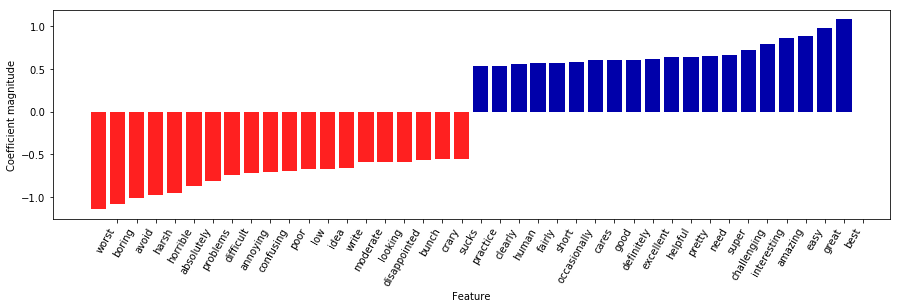

In [83]:
coefs = lr.coef_
mglearn.tools.visualize_coefficients(coefs, feature_names_count, n_top_features = 20)
plt.show()

#### Tuned Model

In [84]:
pipe = make_pipeline(CountVectorizer(stop_words='english'), LogisticRegression(class_weight='balanced'))
param_grid = [{'logisticregression__C':np.logspace(-3, 0, 13)}, 
              {'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (2,2), (2,3), (3,3)]},
             {'countvectorizer__min_df': np.arange(0.005, 0.055, 0.005)}] 
lr_grid = GridSearchCV(pipe, param_grid, scoring='roc_auc', cv = cv)
lr_grid.fit(train, y)
print(lr_grid.best_score_)
print(lr_grid.best_params_)

0.8679023139243457
{'logisticregression__C': 0.05623413251903491}


#### Look at the top features i.e. words (Best Model)

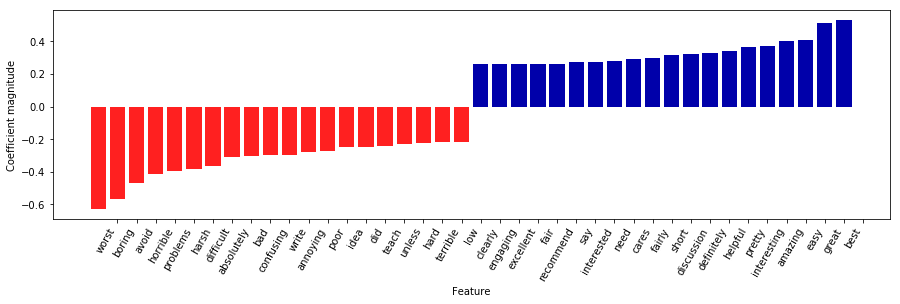

In [85]:
coef_lr_grid = lr_grid.best_estimator_.named_steps["logisticregression"].coef_
vect_count_lr_grid = lr_grid.best_estimator_.named_steps['countvectorizer']
feature_names_count_lr_grid = np.array(vect_count_lr_grid.get_feature_names())
mglearn.tools.visualize_coefficients(coef_lr_grid, feature_names_count_lr_grid , n_top_features = 20)
plt.show()                                                              

#### 3 b) Run Model: TfidfVectorizer

#### Tuned Model

In [86]:
pipe = make_pipeline(TfidfVectorizer(stop_words='english'), LogisticRegression(class_weight='balanced'))
param_grid = [{'logisticregression__C':np.logspace(-3, 0, 13)}, 
              {'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (2,2), (2,3), (3,3)]},
             {'tfidfvectorizer__min_df': np.arange(0.005, 0.055, 0.005)}] 
lr_grid = GridSearchCV(pipe, param_grid, scoring='roc_auc', cv = cv)

lr_grid.fit(train, y)
print(lr_grid.best_score_)
print(lr_grid.best_params_)

0.8935711371451885
{'tfidfvectorizer__min_df': 0.005}


#### Look at the top features i.e. words (Best Model)

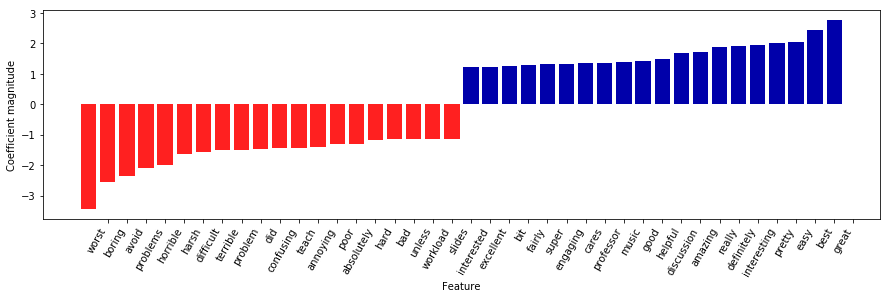

In [87]:
coef_lr_grid = lr_grid.best_estimator_.named_steps["logisticregression"].coef_
vect_count_lr_grid = lr_grid.best_estimator_.named_steps['tfidfvectorizer']
feature_names_count_lr_grid = np.array(vect_count_lr_grid.get_feature_names())
mglearn.tools.visualize_coefficients(coef_lr_grid, feature_names_count_lr_grid , n_top_features = 20)
plt.show()                                                              

# Using Random Forests For Sentiment Analysis (using NLTK results as ground truth)  <a name="modellingtreespranjal"></a>

#### Initial Model

In [38]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(bag_count, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [42]:
scores = cross_val_score(RandomForestClassifier(class_weight='balanced', random_state= 9598), bag_count, y, scoring='roc_auc', cv = cv ) 
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores))) 

Mean cross-validation accuracy: 0.76


#### Tuned Model

In [45]:
pipe_rf = make_pipeline(CountVectorizer(stop_words='english'), RandomForestClassifier(class_weight='balanced', random_state = 9598, max_depth = None,  max_leaf_nodes = None))
rf_grid = [{'randomforestclassifier__n_estimators': np.arange(50, 300, 50)},
           {'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (2,2), (2,3), (3,3)]},
           {'countvectorizer__min_df': np.arange(0.005, 0.055, 0.005)}] 
rf_grid = GridSearchCV(pipe_rf, rf_grid, scoring='roc_auc', cv = cv)
rf_grid.fit(train, y)
print(rf_grid.best_score_)
print(rf_grid.best_params_)

0.8691962464300286
{'randomforestclassifier__n_estimators': 250}


# Unsupervised Analysis: PCA, NMF and Outlier Detection <a name="unsupervisedpranjal"></a>

## PCA 
#### Get the top Principal Components using Truncated SVD

In [88]:
lsa = TruncatedSVD(n_components=100)
lsa.fit_transform(bag_tfidf)
lsa.components_.shape

(100, 13283)

#### Selecting Optimal Principal Components

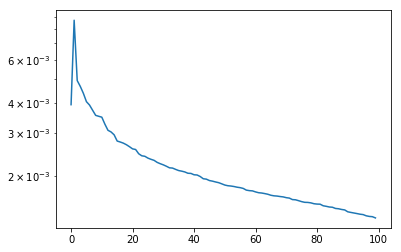

In [62]:
plt.semilogy(lsa.explained_variance_ratio_)
plt.show()

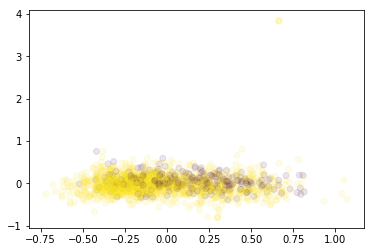

In [63]:
scaler = MaxAbsScaler()
X_scaled = scaler.fit_transform(bag) # Scale the data
lsa_scaled = TruncatedSVD(n_components=100)

X_lsa_scaled = lsa_scaled.fit_transform(X_scaled)

plt.scatter(X_lsa_scaled[:, 1], X_lsa_scaled[:, 3], alpha=.1, c = y)
plt.show()

In [ ]:
####

In [91]:
pipe = make_pipeline(CountVectorizer(stop_words='english'), MaxAbsScaler(), TruncatedSVD(n_components=100), LogisticRegression(class_weight='balanced'))
param_grid = [{'logisticregression__C':np.logspace(-3, 0, 13)}, 
              {'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (2,2), (2,3), (3,3)]},
             {'countvectorizer__min_df': np.arange(0.005, 0.055, 0.005)}] 

lr_grid = GridSearchCV(pipe, param_grid, scoring='roc_auc', cv = cv)
lr_grid.fit(train, y)
print(lr_grid.best_score_)
print(lr_grid.best_params_)

0.8505566241184358
{'logisticregression__C': 0.01}


## Clustering

## Outlier Detection

In [ ]:
train
y

#### Gaussian 

In [ ]:
ee = EllipticEnvelope(contamination=.005).fit(X_scaled) #10% outliers (but can we improve our guess?)
pred_ee = ee.predict(X_scaled) 
print(pred_ee)
print(np.mean(pred_ee == -1))

In [ ]:
print(roc_auc_score(y, pred_ee))

In [ ]:
oneclass = OneClassSVM(nu=.005).fit(X_scaled)
pred_oc = oneclass.predict(X_scaled)
print(pred_oc)
print(np.mean(pred_oc == -1))

In [ ]:
print(roc_auc_score(y, pred_oc))

#### Non-Probability based (and i.e. non-Gaussian)

In [ ]:
isoforest = IsolationForest(max_samples=256, contamination = .005, random_state=9598).fit(X_scaled)
# max_samples=’auto’, contamination=0.1, max_features=1.0, 
# bootstrap=False, n_jobs=1, verbose=0)
pred_if = isoforest.predict(X_scaled) 

In [ ]:
print(roc_auc_score(y, pred_if))

#### NMF Decomposition 

In [85]:
lr_lsa = LogisticRegression(C=100).fit(X_lsa_scaled[:, :10], y)

nmf_scale = NMF(n_components=100, verbose=0, tol=0.01) # verbose tells it to shut up and not update results
nmf_scale.fit(X_scaled)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=100, random_state=None, shuffle=False, solver='cd',
  tol=0.01, verbose=0)

In [65]:
coefs = nmf_scale.components_
feature_names = vect.get_feature_names()

#### LDA 

In [66]:
lda = LatentDirichletAllocation(n_components=10, learning_method="batch")
X_lda = lda.fit_transform(bag)

In [67]:
lda100 = LatentDirichletAllocation(n_components=100, learning_method="batch")
X_lda100 = lda100.fit_transform(bag)

In [ ]:
pd.DataFrame(lda100.components_)

#### LDA Produces Horrible Results: Need to fine tune... 

In [112]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lda, feature_names_tfidf, 10)

Topic %d:
daniel arvind roma dodd friedman 400 heather ml game postings
Topic %d:
dan daniela passages urdu insane pts tyerman miguel janet aftab
Topic %d:
stats levy korean rubenstein kim karen lead varzi mowsh experiment
Topic %d:
class professor final really workload course midterm students just time
Topic %d:
bayer ellsberg arbitrary af como postings christia blake cohen meaningful
Topic %d:
lilla nathan taylor quantum vogel krauss algos christina samuel carefully
Topic %d:
african crary dani film opaque garb dont clarity asian happens
Topic %d:
reports lab semesters answered struggle planning gen listenings drill arabic
Topic %d:
genius dont baker approximation insanely zarghamee ieee bro rieder gamber
Topic %d:
qi luke laoshi plays xavi neath sachin kat intaglio cloud


## Genism -- Continue Here
https://amueller.github.io/COMS4995-s18/slides/aml-21-041118-word-embeddings/#p37

In [69]:
docs = train
texts = [[token for token in doc.lower().split()] for doc in docs]

In [70]:
dictionary = corpora.Dictionary(texts)
print(dictionary)

Dictionary(27373 unique tokens: ['amount', 'at', 'average', 'best', 'columbia.']...)


In [71]:
corpus
gensim.matutils.corpus2csc(corpus)
X = CountVectorizer().fit_transform(docs)
X

NameError: name 'corpus' is not defined

In [ ]:
sparse_corpus = gensim.matutils.Sparse2Corpus(X.T)
print(sparse_corpus)
print(list(sparse_corpus))


---
# Old code <a name="oldcode"></a>

### Webscraping (IDs 20000 to 20100) [Weida]

In [80]:
'''
from bs4 import BeautifulSoup 
import re
from urllib.request import urlopen 
import pandas as pd
from tqdm import tqdm #shows progress

df_200_201 = pd.DataFrame(columns=['review_id', 'review_date' ,'review_text', 'agree_score', 'disagree_score',
                             'funny_score', 'professor_id', 'professor_name'])
for i in tqdm(range(20000, 20100)):
    url = 'http://culpa.info/reviews/{}'.format(i)
    r = urlopen(url).read() 
    soup = BeautifulSoup(r, "lxml") 
    # if review doesn't exist, it redirects to home page, maybe use len() to check if we got redirected
    if len(soup.text) > 15500:
        continue

    professor_id = int(soup.find(href=re.compile('(professor)'))['href'][12:])
    professor_name = soup.find(href=re.compile('(professor)')).text
    review_id = int(soup.find(href=re.compile('(reviews)'))['href'][9:])
    review_text = soup.find(class_='review_content').text
    review_date = pd.Timestamp(soup.find(class_='date').text.strip())
    agree_score = int(re.findall('\d+', soup.find(class_='agree')['value'])[0])
    disagree_score = int(re.findall('\d+', soup.find(class_='disagree')['value'])[0])
    funny_score = int(re.findall('\d+', soup.find(class_='funny')['value'])[0])

    to_append = pd.DataFrame(data=[review_id, review_date, review_text, agree_score, 
                              disagree_score, funny_score, professor_id, professor_name],
                            index=['review_id', 'review_date' ,'review_text', 'agree_score', 
                              'disagree_score', 'funny_score', 'professor_id', 'professor_name']).T
    
    df_200_201 = pd.concat([df_200_201, to_append], ignore_index=True)
'''

100%|██████████| 100/100 [01:45<00:00,  1.05s/it]


#### Check out the scraped data: : First 5 Rows

In [8]:
df_200_201.head()

,review_id,review_date,review_text,agree_score,disagree_score,funny_score,professor_id,professor_name
0,20000,2007-05-18 00:00:00,\nComing off a semester of very little work in...,0,0,0,3281,"Veneziano Broccia, Lillyrose"
1,20001,2007-05-18 00:00:00,\nI had Professor Robbins for a lecture in the...,4,2,0,744,"Robbins, Bruce"
2,20002,2007-05-18 00:00:00,\nIt's a little hard for me to criticize Profe...,5,2,0,115,"Sacks, Richard"
3,20003,2007-05-18 00:00:00,\nThis class was a disaster. Professor Daniel ...,4,2,0,456,"Daniel, Valentine"
4,20004,2007-05-19 00:00:00,\nLovely class and professor. The class was mo...,3,3,0,2371,"Radwan, Noha"


### Weights

Formula to calculate weights while iterating (Sorry, can't get it to function -- brain dead right now haha :P)
#### Can anyone fix this?
- **skipped using loops, refer to above [weida]**

In [136]:
weighted_score = pd.DataFrame({'weighted_score' : []}) #empty pandas column

for i in tqdm(range(len(subset.index))): #iterate over length of dataframe (i.e. subset.index)
    denominator = subset.loc[i,'agree_score'] + subset.loc[i,'disagree_score']
    
    if denominator != 0: #to avoid math error 
        weights = subset.loc[i,'agree_score'] / denominator
        w_score = subset.loc[i,'compound'] * weight #calculate weighted score (w_score)
        weighted_score.append(w_score) #append it to the empty pandas column

subset = pd.concat([subset, weighted_score], ignore_index=True) #add to the our dataframe, subset


  0%|          | 0/20 [00:00<?, ?it/s]


TypeError: cannot concatenate a non-NDFrame object